***
<header>
<h1><center>SPATIAL CROSS-VALIDATION</center></h1>
<h2><center>FOR MODEL ASSESSMENT AND SELECTION</center></h2>
<h3><center>REID FALCONER</center></h3>
</header>
***

In [2]:
# Load Required Libraries 
list.of.packages <- c("ModelMetrics", "sperrorest", "mvnfast", 
                      "knitr", "tictoc", "IRdisplay", "kableExtra", 
                      "raster", "tmap", "sf", "tidyverse")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
sapply(list.of.packages, require, character.only = TRUE)

ModelMetrics   sperrorest      mvnfast        knitr       tictoc    IRdisplay 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
  kableExtra       raster         tmap           sf    tidyverse 
        TRUE         TRUE         TRUE         TRUE         TRUE

# Introduction
<p style='text-align: justify;'>
Two essential steps in statistical learning applications are model assessment and model selection. For these, one often employs a cross-validation (CV) procedure which assumes that the data is independent. However, geographic information system (GIS) datasets represent an example where this independence assumption naturally does not hold due to spatial autocorrelation (SAC), where observations close to each other in space have related values. (Legendre 1993). SAC and its effects on spatial data analysis have been extensively studied in the spatial statistics literature (Legendre 1993). For example, it has been shown that the failure to account for the effect of SAC in spatial data modelling can lead to over-complex model selection and produce optimistically biased prediction performance results. 
<br> <br> 
There are numerous applications involving spatial data which have problems caused by SAC in the datasets, such as natural resource detection, route selection, construction placement, natural disaster recognition, tree species detection, environmental monitoring, etc. [Figure 1](#figure_1) shows this phenomenon in a small sample of landslide locations collected by Muenchow, Brenning, and Richter (2012). Note how the landslides cluster together, so any attributes related to landslides, e.g., slope, soil type and terrain, will also show similar spatial clustering patterns. 
<br>  <br> 
To counter the problems caused by SAC in spatial modelling, one usually tries to incorporate spatial autocorrelation as an autocovariate factor into the prediction models themselves, e.g. autocovariate models, spatial eigenvector mapping and autoregressive models. However, despite these techniques for spatial prediction, little attention has been given to assessing the spatial prediction performance of a model and model selection via cross-validation. Therefore, in this notebook I will focus on the use of cross-validation for model assessment and model selection, with two primary goals:
<br> <br> 
**1.** To motivate and survey extensions of cross-validation to spatial data. <br> 
**2.** To show that spatial cross-validation methods indeed outperform non-spatial ones at both model assessment and model selection using simulated data. 
<br>
</p>

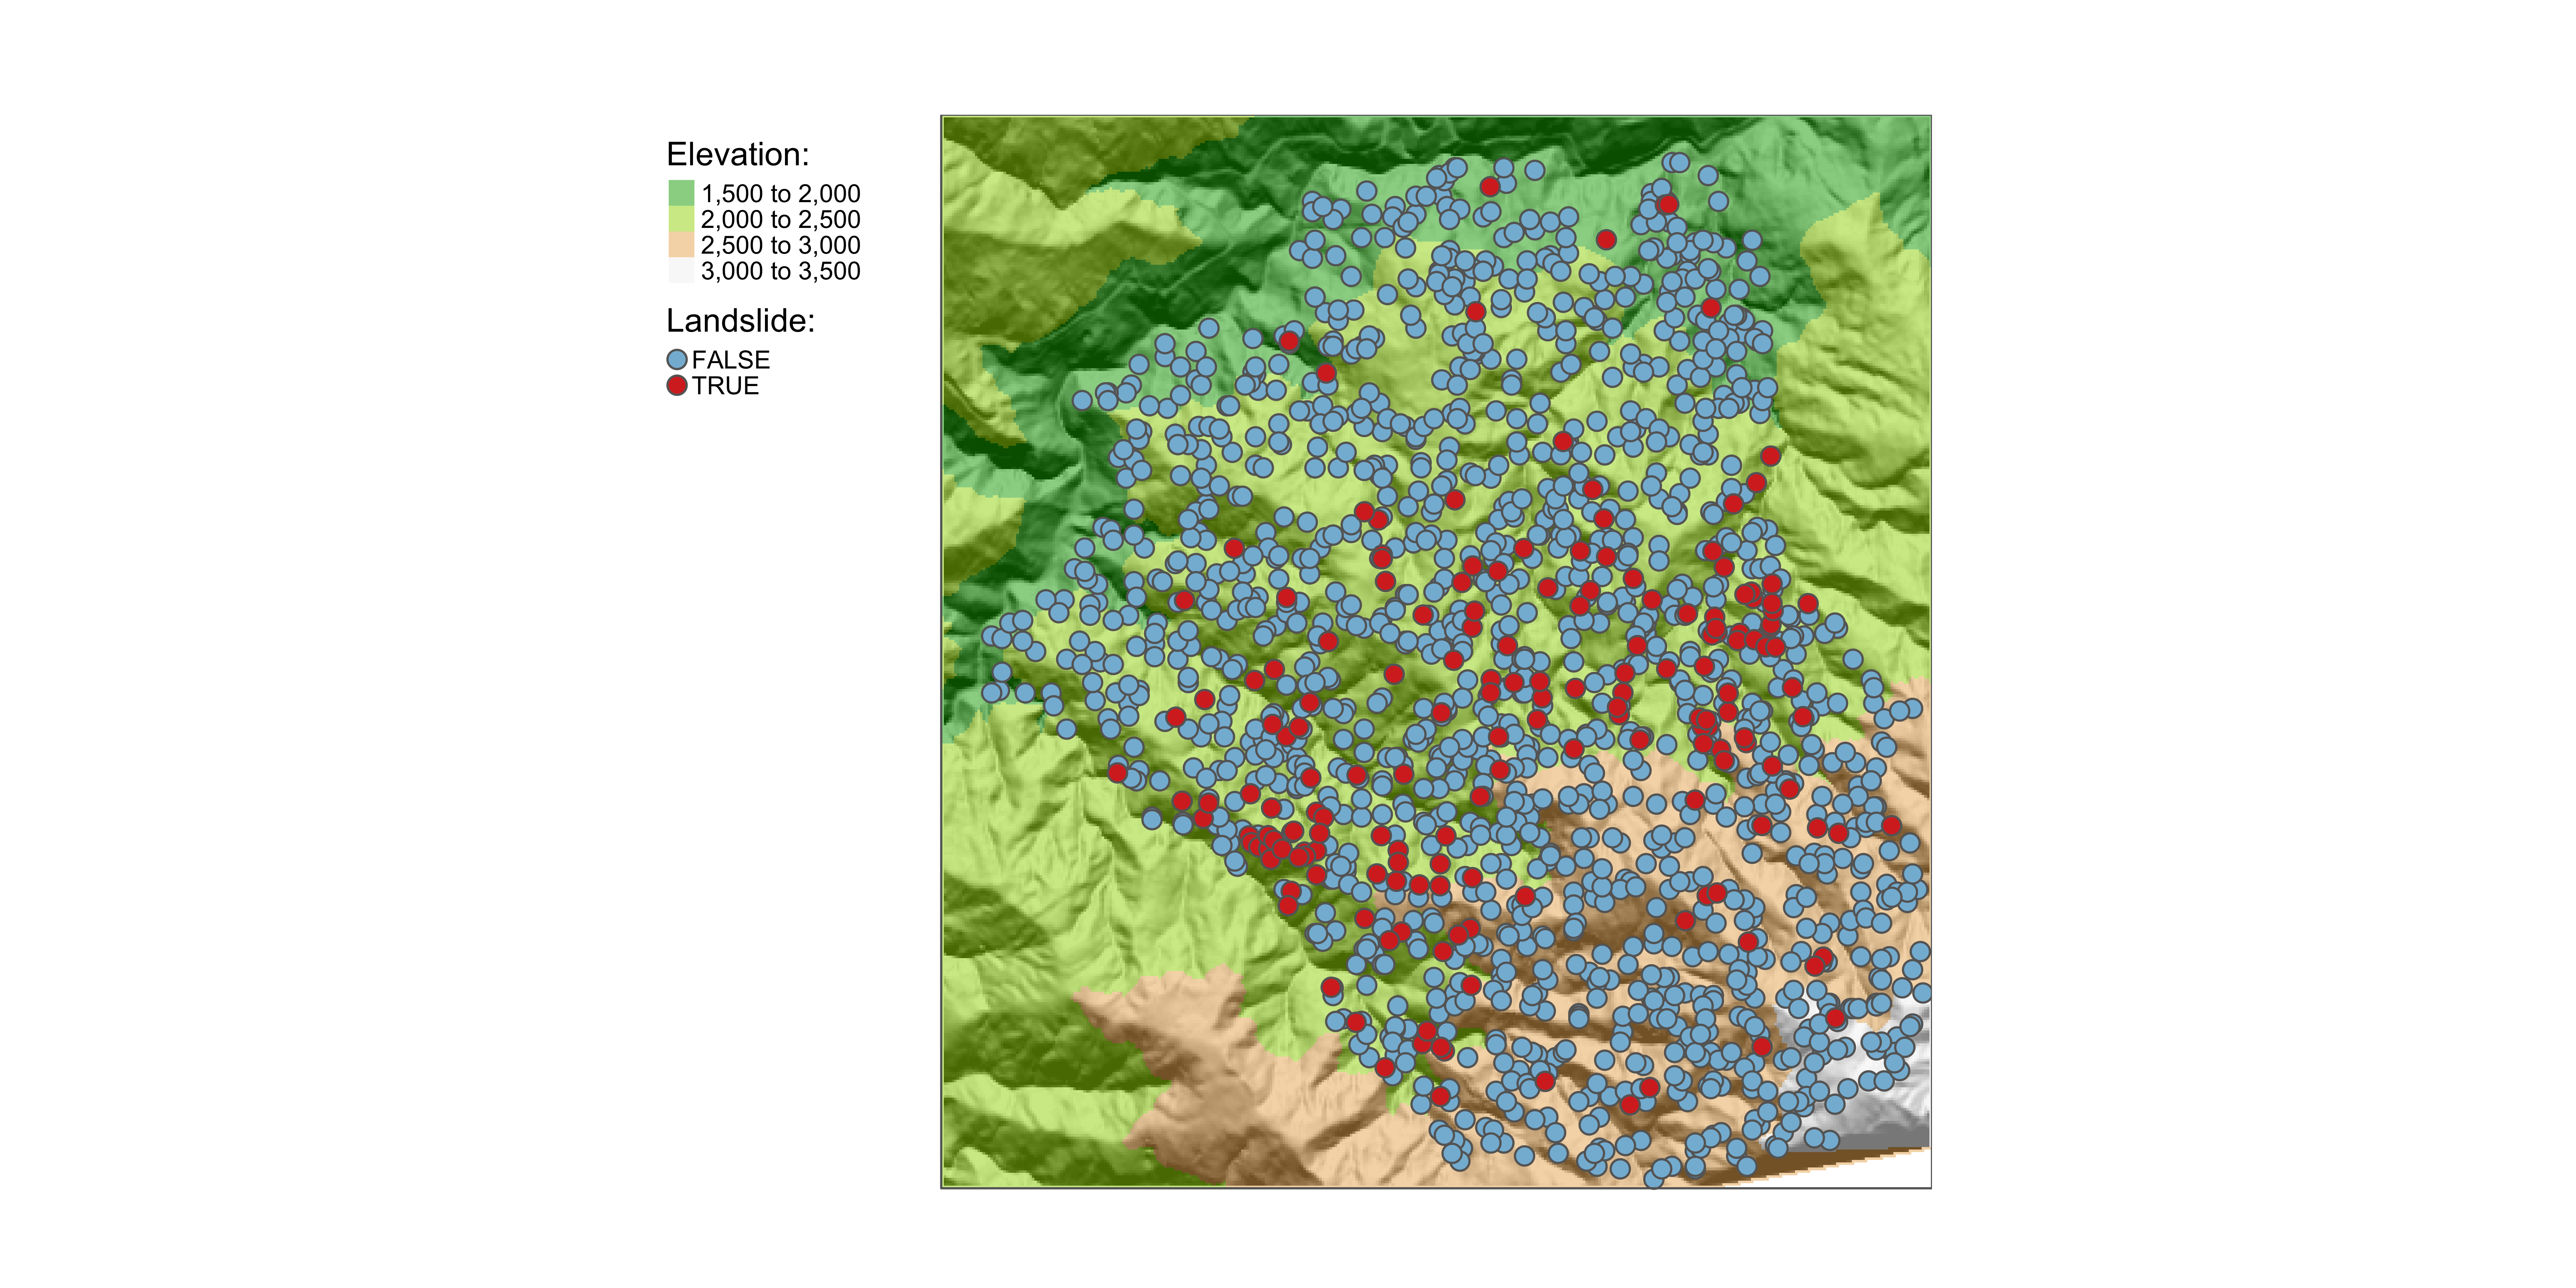

In [3]:
# Code for Figure 1
{options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 600)
data("landslides", package = "RSAGA")
data("ta", package = "spDataLarge")

# select non-landslide points
non_pts = filter(landslides, lslpts == FALSE)
# select landslide points
lsl_pts = filter(landslides, lslpts == TRUE)
# create smaller landslide dataset (lsl)
lsl = bind_rows(non_pts, lsl_pts)

lsl_sf = st_as_sf(lsl, coords = c("x", "y"), crs = 32717)
hs = hillShade(ta$slope * pi / 180, terrain(ta$elev, opt = "aspect"))
rect = tmaptools::bb_poly(hs)
bbx = tmaptools::bb(hs, xlim = c(-0.3, 1), ylim = c(-0.01, 1), relative = TRUE)
tm_shape(hs, bbox = bbx) +
    tm_raster(palette = gray(0:100 / 100), n = 100, legend.show = FALSE) +
    tm_shape(ta$elev) +
    tm_raster(alpha = 0.5, palette = terrain.colors(10), legend.show = TRUE, title = "Elevation: ") +
    tm_shape(lsl_sf) + 
    tm_bubbles("lslpts", size = 0.2, palette = "-RdYlBu", title.col = "Landslide: ") +
  qtm(rect, fill = NULL) +
    tm_layout(outer.margins = c(-0.02, 0, 0, 0), frame = FALSE) +
  tm_legend(bg.color = "white")
 }

# Cross-Validation in a Spatial Context

<p style='text-align: justify;'>
As previously mentioned spatial autocorrelation often leads to difficulties with statistical methods because many methods assume that observations are independent and identically distributed (i.i.d.). Spatial autocorrelation, however, means that drawing one observation implies that nearby observations will likely be similar to it, thus making it unreasonable to assume that points are i.i.d. As such, many methods, including modelling and model assessment methods, perform worse when naively applied to spatial data.
<br> <br> 
Interestingly, cross-validation does not necessarily assume that observations are i.i.d. Instead, it depends on a modified assumption of independence based on sampling and resampling. When researches gather data, they collect a random sample from the population. CV simulates sampling by resampling; rather than sampling from the whole population, CV resamples from the given dataset.
<br> <br> 
CV assumes that the original sample is representative of the population and that its resamples are collected in the same way that a new sample from the population would be collected. If observations are i.i.d., then this assumption is trivially satisfied. Without an i.i.d. assumption, though, the assumption still holds for spatial data so long as the resampled training and validation sets are collected in the same manner as the original sample was: collected in spatial groups.
<br> <br> 
However, K-fold CV does not resample spatial groups of data. Alternatively, it uses random resampling, which produces training and validation sets whose points are distinct but come from overlapping spatial regions. To illustrate this point, [Figure 2](#figure_2) gives an example of how one fold of 5-fold CV might partition points into a training set (white points) and a validation set (black points).
<br> <br> 
</p>
<a id='figure_2'></a>
<div style="width:image width px; font-size:100%; text-align:center;"><img src="../images/5foldcv.jpg" alt="alternate text" width="300" height="300" style="padding-bottom:0.5em;" />Figure 2: Example of 5-fold CV fold <br> Source: Own Compilation</div> 

<p style='text-align: justify;'>
Having training-set points interspersed among validation-set points leads to three main challenges for model assessment. **First**, the presumed independence between the training set and the validation set is broken. Consider the validation-set point $a$ in [Figure 2](#figure_2). As indicated by the dotted circle, $a$ is very close to two other points in its corresponding training set. Due to spatial autocorrelation, knowing information about the two nearby training-set observations gives information about $a$. To clarify, suppose that $a$ has a response $y_a$ of the form $y_a = f(\textbf{x}_a) + \epsilon_a $. The training-set points near $a$ would not only tend to have $\textbf{x}_i$ similar to $\textbf{x}_a$, but also tend to have $\epsilon_i$ similar to $\epsilon_a$. Thus, if a model overfits the training set, it would perform exceptionally well on $a$, which would undermine the rationale for using a validation set.
<br> <br> 
The **second** challenge is that the spatial autocorrelation structures in the training set are not preserved. The training set in [Figure 2](#figure_2) contains observations that are more spread out in space, on average, than the original training set. As such, the observations do not exhibit the same degree of spatial autocorrelation as the original training set, which can affect model training.
<br> <br> 
The **third** and final challenge relates to interpolation and extrapolation. Researchers usually want to assess model extrapolation: how well models can predict observations in spatial regions other than those of the original samples. Such observations will often have different latent-variable values. Interspersing training-set points among validation-set points, however, leads to similarities between the latent-variable values of the training and validation sets, since they are drawn from overlapping spatial regions. Thus, K-fold CV would be better at assessing model interpolation: how well the models can predict observations in the same spatial area as the training set but not model extrapolation.
</p>

# Methods to Account for Spatial Autocorrelation

<p style='text-align: justify;'>
The aforementioned theoretical issues with K-fold CV in spatial contexts have led researchers to explore the effects of spatial autocorrelation on model assessment. This research has shown that ignoring spatial autocorrelation falsely inflates assessments of model accuracy and that using K-fold CV error for assessment leads to over-optimistic error estimates for models that overfit the data. Specifically, because CV is highly sensitive to the average distances
between training and validation points (see Roberts et al. (2017)), the proximity of training and validation data in
K-fold CV leads to artificially low error estimates for models that can incorporate the information about the validation data contained in the training data.
<br> <br> 
Nevertheless, there are many ways to modify CV to account for the challenges induced by SAC. For spatial data, the resampling in CV needs to mirror the original sampling, so resampled points should be spatially grouped/clustered. [Figure 3](#figure_3) below shows an example. On the left, the solid black circles are points that have been randomly sampled (top-left) and resampled (bottom-left). On the right, points are sampled and resampled in spatial clusters. Note that while the sampled/resampled points on the left are uniformly spread across the rectangle, the sampled/resampled points on the right are closer together, which preserves the spatial relationships in the data. 
<br> <br> 
Grouping observations together in specific ways for CV is known as blocking (Roberts et al. 2017). Intuitively, blocking changes the units of resampling from individual observations to user-defined blocks of observations. There are many blocking methods, but this notebook will focus on spatial blocking, where blocks are groups of observations that are close to each other in space (x, y coordinates). Another modification of CV for spatial data involves the use of buffer regions, which are simply points spatially located between the defined training and validation sets that are used in neither set. Using buffer regions accomplishes two goals. First, it reduces the dependencies between points near the edges of training and validation sets (Le Rest et al. 2014). Second, it adds distance between training and validation sets, which increases the amount of extrapolation in a model’s predictions on a validation set (Roberts et al. 2017). In summary, spatial blocking and buffering provide solutions, at least theoretically, to the issues caused by SAC. The following section explores how blocking and buffering can be incorporated into cross-validation.
<br> <br> 
<a id='figure_3'></a>
<div style="width:image width px; font-size:100%; text-align:center;"><img src="../images/spatialcv.jpg" alt="alternate text" width="500" height="400" style="padding-bottom:0.5em;" />Figure 3: Random sampling/resampling vs. spatially grouped sampling/resampling <br> Source: Own Compilation </div> 
</p> 

## Spatial Cross-Validation

<p style='text-align: justify;'>
Spatial cross-validation involves modifications of CV for spatial data. Instead of defining folds of points at random, folds are defined by spatial boundaries. The most basic case of spatial CV is called grid cross-validation, which defines spatial folds by dividing the data into rectangular regions. The data in each block in the resulting grid is then used as a "fold" for K-fold CV. Additionally, one can incorporate buffer regions into the grid CV which is called buffered grid cross-validation.
<br> <br> 
Other methods incorporate buffer regions in different ways. For example, spatial leave-one-out cross-validation (SLOO CV), proposed in Le Rest et al. (2014), is a natural spatial variation of leave-one-out CV. Rather than excluding only one observation from the training set in each fold, SLOO CV excludes all observations within a small buffer region of the validation observation to preserve independence. 
<br> <br> 
Conversely, Brenning (2012) argues against buffer regions and proposes a variation of grid cross-validation called spatial K-fold cross-validation (SKCV), where each fold, is a spatial partition derived from using a k-means clustering algorithm on the spatial data coordinates. To help visualise these methods, [Figure 4](#figure_4) illustrates one fold each of buffered grid CV, SLOO CV, and SKCV (respectively). Black points are points in the validation set, grey points are points in the buffer, and white points are points in the training set for the given fold.
<br> <br> 
<a id='figure_4'></a>
<div style="width:image width px; font-size:100%; text-align:center;"><img src="../images/example_cvs.jpg" alt="alternate text" width="750" height="500" style="padding-bottom:0.5em;" />Figure 4: One fold of buffered grid CV, SLOO CV, and SKCV <br> Source: Own Compilation</div> 
</p>

<p style='text-align: justify;'>
The three cross-validation techniques in [Figure 4](#figure_4) differ in the sizes of their training sets, validation sets, and buffer regions, which theoretically affects their bias and variance. Buffer regions are particularly interesting with respect to bias and variance. Their primary role is to increase independence between training and validation sets, which should reduce the optimistic bias of non-spatial error estimates. Buffers also reduce overlaps between training sets by removing points from each training set, which may decrease estimate variance. At the same time, buffer regions remove data that would have otherwise been used for training, which may cause pessimistic bias. Furthermore, the described buffering methods all remove random numbers of points, which can increase estimate variance. Since buffer regions may theoretically affect bias and variance in many ways, the simulation-based results will be important to understand their effects better.
</p>
##### The code chuck below outlines both the non-spatial and spatial CV techniques.

In [4]:
# CROSS VALIDATION PROCEDURES 

# 1) K-fold CV (generlised to LOOCV when nfolds = npoints i.e K = N)
# 2) Buffered Grid CV
# 3) Spatial Leave One Out CV (SLOO CV)
# 4) K-fold Spatial CV (SKCV) (Exploits KNN for folds)

# INPUTS:
# - data frame
# - number of folds
# - (model formula)
# - (model parameters)

# OUTPUT:
# - CV error estimate (RMSE)

# Non-Spatial CV Procedures 

# K-fold CV 
cv_lm <- function(df, nfolds, model_formula) {
  cv_errors <- vector(mode = "numeric", length = nfolds)
  
  # Shuffle data and partition folds
  temp <- df[sample(nrow(df)),]
  folds <- cut(seq(1,nrow(temp)),
               breaks = nfolds,
               labels = FALSE)
  for(i in 1:nfolds){
    # Split training/testing sets
    test_index <- which(folds==i, arr.ind = TRUE)
    test <- temp[test_index, ]
    train <- temp[-test_index, ]
    # Fit lm
    fitted_model <- lm(model_formula, data = train)
    # Store error
    diffs <- predict(fitted_model, test) - test$val
    cv_errors[i] <- mean(diffs^2)
  }
  return(sqrt(mean(cv_errors)))
}

# Spatial Cross Validation Procedures 

# Buffered Grid CV
cv_grid_buffer_lm <- function(df, nrow, ncol, model_formula) {
  # Use sperrorest package (Brenning, 2012) to partition data into spatial folds
  nfolds_spat <- nrow*ncol
  partition <- partition_tiles(
    as.data.frame(df),   
    nsplit = c(ncol,nrow),  # nrow x ncol grid
    reassign = FALSE)       # Don't reassign observations in small folds
  
  # Hacky method to number which fold each observation is in
  all_folds <- partition$`1`
  count = 1
  fold_df <- df %>%
    select(x, y)
  for (fold in all_folds){
    varname <- paste("fold", count, sep = "")
    fold_df <- fold_df %>%
      mutate(!!varname := count*(row_number() %in% fold$test))
    count <- count + 1
  }
  folds <- rowSums(fold_df[,c(3:ncol(fold_df))])
  df_spatial <- df %>%
    mutate(fold = folds)
  
  # Find fold neighbors of each fold (again, hacky)
  fold_neighbors <- vector(mode = "list", length = nfolds_spat)
  for (i in 1:nfolds_spat) {
    list1 <- c(i, i-nrow, i+nrow)
    list2 <- switch(as.character(i %% nrow),
                    "0" = c(i-1, i-1-nrow, i-1+nrow),
                    "1" = c(i+1, i+1-nrow, i+1+nrow),
                    c(i-1, i-1-nrow, i-1+nrow, i+1, i+1-nrow, i+1+nrow))
    fold_neighbors[[i]] <- c(list1, list2)
  }
  
  # Compute buffered grid CV error
  results_list <- vector(mode="numeric", length = nfolds_spat)
  num_empty_folds <- 0
  for (j in 1:nfolds_spat) {
    train <- df_spatial %>% filter(!(fold %in% fold_neighbors[[j]]))
    test <- df_spatial %>% filter(fold == j)
    if (dim(test)[1] == 0) {   # If test set is empty
      num_empty_folds <- num_empty_folds + 1
      next
    }
    # Train model & make predictions
    model_lm <- lm(model_formula, data = train)
    model_preds <- predict(model_lm, test)
    # Store results
    results_list[[j]] <- rmse(model_preds, test$val)
  }
  return(sum(unlist(results_list)) / (nfolds_spat - num_empty_folds))
}

# Spatial leave one out cross validation (SLOO CV)
cv_SLOO_lm <- function(df, buffer, model_formula) {
  model <- sperrorest(
    model_formula,
    data=df,
    coords=c("x", "y"),   # variables that contain x/y coordinates
    model_fun = glm,
    pred_fun = predict,
    smp_fun = partition_loo,   # SLOO
    smp_args = list(repetition = 1,
                    buffer = buffer,
                    seed1 = 123),   # 1 repetition
    progress=FALSE)
  return(summary(model$error_rep)["test_rmse",]$mean)
}

# Spatial K-fold CV
cv_spatial <- function(df, nfolds, model_formula) {
    model <- sperrorest(
      model_formula,
      data=df,
      coords=c("x", "y"),   # variables that contain x/y coordinates
      model_fun=glm,
      pred_fun=predict,
      smp_fun=partition_kmeans,   # SKCV - Using K-Means Algorithm - see sperrorest package for more info
      smp_args = list(repetition = 1,
                      nfold = nfolds,
                      seed1 = 123),   # 1 repetition
      progress=FALSE)
    return(summary(model$error_rep)["test_rmse",]$mean)
}

# Simulations
<p style='text-align: justify;'>
The above work has outlined the heuristic justifications for why spatial blocking and buffering should improve CV model assessment and selection on spatial data. However, few studies have compared such techniques to the conventional methods. Thus, this sections takes some small steps toward addressing this gap in the literature. Here I compare spatial versus non-spatial cross-validation techniques on simulated spatial data, concluding with some preliminary results.
<br> <br> 
Ultimately, the simulations aim to show that for spatially structured data, spatial resampling methods outperform non-spatial methods. To do so, I adopt a simulation procedure close in spirit to that of Roberts et al. (2017), running two simulations: one for *model assessment*, and another for *model selection*.
<br> <br> 
Both simulations begin as follows. First, I generate 100 datasets, each containing 500 points placed uniformly at random in a $100 \times 100$ grid. For each point, I randomly generate spatially correlated variables $x_1$, $x_2$, and $x_3$ and spatially correlated noise $\epsilon_{spatial}$. Finally, I generate the response value as $f(x_1; x_2; x_3) + \epsilon_{spatial} + \epsilon$, where $\epsilon$ is non-spatial random noise. 
<br> <br> 
For each dataset $D$, the true conditional error $Err_D$ of the given model is computed by fitting the model to $D$ and computing its average root-mean-square error (RMSE) over all 99 other datasets. Intuitively, I treat the other 99 datasets as a large draw from the same population as $D$, so performance on that large sample should be a good estimate of performance on the overall population. Expected error $Err$ is computed by taking the average of all 100 $Err_D$ values.
</p>

##### The function used to randomly generate the spatially correlated data is highlighted below (see  `generate_sample` function)

In [5]:
# Build function to randomly generate spatially correlated data

# INPUT: 
#  - true function f:(x1 + x2 + x3) -> y
#  - whether variables & noise are independent or spatially correlated
#  - (maximum x-coordinate)
#  - (maximum y-coordinate)
#  - (number of points)
#  - (SD of noise)

# OUTPUT: df with `npoints` points, each with:
#  - x/y coordinates
#  - x1,x2 and x3 values, where xi's are spatially correlated
#  - Y values from f(X1 + X2 + X3) + e + e_spatial

# Two kinds of noise are added:
#  1) Independent normal noise N(0, sigma)
#  2) Spatially autocorrelated noise

generate_sample <- function(f, spat_vars, spat_noise, max_x=100, max_y=100, npoints=500, sigma=0.5, decay=10) {
  # Generate x/y coordinates, uniformly across space
  x <- runif(npoints, 0, max_x)
  y <- runif(npoints, 0, max_y)
  df <- data.frame(x,y)
  
  if(spat_vars){
    # Spatially dependent covariance matrix
    mat <- as.matrix(proxy::dist(df))    # distance matrix
    sigma_mat <- 1 - mat/(mat+decay)     # decaying function to simulate distance decay
    sigma_mat <- (sigma^2)*sigma_mat     # diagonals equal variance
  } else{
    # Independent covariance matrix
    sigma_mat <- diag(npoints)
  }
  
  vars <- rmvn(
    n=3,                  # number of variables to generate (without noise)
    mu=rep(0, npoints),   # vector of variable means
    sigma = sigma_mat, 
    ncores = 4)
  
  if(spat_noise){
    if(!spat_vars){
      # Generate sp. dep. cov. matrix if haven't done so yet
      mat <- as.matrix(proxy::dist(df))   # distance matrix
      sigma_mat <- 1 - mat/(mat+decay)    # decaying function to simulate distance decay
      sigma_mat <- (sigma^2)*sigma_mat    # diagonals equal variance
    }
    # Spatially dependent noise 
    noise <- as.vector(rmvn(
      n=1,
      mu=rep(0, npoints),
      sigma = sigma_mat, 
      ncores = 4))
  } else{
    # Spatially independent noise
    noise <- rnorm(npoints, 0, sigma)
  }
  
  # Add another layer of nonspatial noise
   extra_noise <- rnorm(npoints, 0, sigma)
   noise <- noise + extra_noise
  
  df <- cbind(df, t(vars), noise)
  colnames(df) <- c("x","y","X1","X2","X3","eps")
  df <- df %>%
    mutate(val = f(X1,X2,X3) + eps)
  return(df)
}

## Model Assessment Simulation
<p style='text-align: justify;'>
The model assessment simulation compares the true errors of linear models to the error estimates produced by training error, 16-fold CV error, LOO CV error, 4x4 buffered grid CV error, SLOO CV error (with buffer size 15) and 16-fold spatial CV error. I choose to use 16-fold CV rather than 10-fold CV (as suggested in the literature) and a buffer size of 15 for the SLOO CV because there resulting validation sets are more similar in size to those of $4 \times 4$ buffered grid CV, which is better for comparing the methods. 
<br> <br> 
The data-generating function used is:
<br> <br> 
$$
f ( x_1 , x_2 , x_3 ) = 2 \sin ( \pi x_1 ) + x_1 + 2 x_2 + 4 * 1_{x_3 > 0} ( x_3 )
$$
<br> <br> 
where $1_{x_3>0}(x_3)$ is the indicator function that is $1$ if $x_3 > 0$ and $0$ otherwise. This is done in an attempt to make make the signal roughly linear, but complex enough that the learning curve for a linear model will not achieve a minimum with too few training observations, which would eliminate the pessimistic bias that K-fold CV suffers for low values of K.
<br> <br> 
For each simulated dataset, $D$, I compute the aforementioned five estimates of the out-of-sample error of the linear model $m: y \sim x_1 + x_2 + x_3$. [Table 1](#table_1) shows the average values of the five error estimates over the 100 simulated datasets, along with the average true error $Err$. As expected, the training error is the most optimistic assessment method and reassuringly, one notices that the non-spatial CV methods are significantly more optimistic than the spatial CV methods.
</p>

##### The code chuck below defines the parameters for simulations.

In [6]:
# SIMULATIONS

# Define parameters for simulation 
SEED <- 100
set.seed(SEED)
MAX_X <- 100   # Boundaries of data to use
MAX_Y <- 100
NUMSAMP <- 100   # Number of simulation samples to generate
NPOINTS <- 500   # Number of points per sample
NFOLDS <- 16   # Number of folds for K-fold cv and SKCV
NROW <- 4   # Number of rows for grid CV
NCOL <- 4   # Number of columns for grid CV
BUFFER <- 15   # Buffer for SLOO CV

**NB: Please note that the code chunk below involves multiple simulations and thus it is not feasible to run in a short time (it takes approximately 25 minutes). Therefore, I have included the results of the simulations in the next code block, which can be read in directly [here](#code_1).**

In [7]:
# Simulation study of different methods for estimating errors

# METHODS:
# Data: simulated data
#  - 500 observations on 100x100 grid
#  - Spatially correlated variables X1, X2, X3
#  - Spatially correlated noise
# True model: function of  X1, X2, X3
# Fit model: linear regression
# CV strategies:
#  1) Training error
#  2) K-fold CV
#  3) LOO CV
#  4) Buffered Grid CV
#  5) Spatial LOO CV
#  6) Spatial K-Fold CV 
# Error metric: RMSE
for (tuple in list(c(T,T))) {
    
  tic()
    
  SP_VARS <- tuple[1]   # Whether vars are spat. correlated. Default = TRUE 
  SP_NOISE <- tuple[2]   # Whether noise is spat. correlated. Default = TRUE

  # Define true model
  f <- function(a,b,c){
    # original function
    return(2*sin(pi*a)+a+2*b+4*(c>0))
  }
  
  model_formula <- as.formula("val ~ X1 + X2 + X3")
  
  # Generate random samples
  all_samps <- vector(mode = "list", length = NUMSAMP)
  all_samps <- lapply(all_samps, function(x) {
    generate_sample(f, spat_vars = SP_VARS, spat_noise = SP_NOISE, npoints = NPOINTS)})
  
  # Compute true error and error estimates (1-5) for each sample
  err_df <- data.frame()
  for (i in 1:NUMSAMP) {
    # Get sample i to use for training
    df_sim_i <- all_samps[[i]]
    
    # Fit lm to df_train
    model_lm <- lm(model_formula, data = df_sim_i)
    
    # Compute test errors on all other training sets
    get_err <- function(df) {
      rmse(df$val, predict(model_lm, df))
    }
    errs_test <- unlist(lapply(all_samps, get_err))
    # Compute true error (need to remove error for df_sim_i)
    err_true <- (sum(errs_test)-errs_test[i]) / (NUMSAMP-1)
    
    # Compute training error (1)
    err_train <- rmse(predict(model_lm, df_sim_i), df_sim_i$val)
    
    # Compute K-fold CV error (2)
    err_cv <- cv_lm(df_sim_i, NFOLDS, model_formula = model_formula)
    
    # Compute LOO CV error (3)
    err_loo <- cv_lm(df_sim_i, NPOINTS, model_formula = model_formula)
    
    # Compute buffered grid CV error (4)
    err_grid <- cv_grid_buffer_lm(df_sim_i, NROW, NCOL, model_formula = model_formula)
    
    # Compute SLOO CV error (5)
    err_sloo <- cv_SLOO_lm(df_sim_i, BUFFER, model_formula = model_formula)
    
    # Compute Spatial K-fold CV error (6)
    err_scv <- cv_spatial(df_sim_i, NFOLDS, model_formula=model_formula)
    
    # Bind all the results of the assesments
    err_df <- rbind(err_df, c(i, err_true, err_train, err_cv, err_loo, err_grid, err_sloo, err_scv))
      
  print(i) # keep track of progress while simulation is running. (1 - 100)
      
  }
  colnames(err_df) <- c("set_number", "err_true", "err_train", "err_cv",
                        "err_loo", "err_grid_buffer", "err_sloo", "err_scv")
  
  # Output results from model assesments
  output_rmse <- err_df
    
  # run time  
  toc()
}

In [8]:
# save the output_rmse for future use
#saveRDS(output_rmse,"../data/output_rmse.RDS")

<a id='code_1'></a>

In [9]:
# read in simulation results `output_rmse` 
output_rmse <- readRDS("../data/output_rmse.RDS")

<a id='table_1'></a>

In [10]:
# Code for Table 1
{output_rmse %>%
    rename(`Training Error` = err_train,
         `16-Fold CV` = err_cv,
         `LOO CV` = err_loo,
         `4 x 4 Buffered Grid CV` = err_grid_buffer,
         `SLOO CV` = err_sloo,
         `16-Fold Spatial CV` = err_scv,
         `True Error` = err_true) %>%
    gather(
        key=Method, value=estimate, 
        `True Error`:`16-Fold Spatial CV`) %>%
    group_by(Method) %>%
    summarize("Average Estimate" = mean(estimate)) %>%
    arrange(factor(`Average Estimate`)) %>%   # reorder rows
    kable("html",  caption = "Table 1: Average error estimates from five assessment methods, and true error") %>% 
    column_spec(c(1), bold = T) %>%
    kable_styling("hover", full_width = T) %>%
    row_spec(0, bold = T, color = "black", background = "lightgrey")  %>%
    as.character() %>%
    IRdisplay::display_html()
 }

Table 1: Average error estimates from five assessment methods, and true error 
 
 
 Method 
 Average Estimate 
 
 
 
 
 Training Error 
 1.671482 
 
 
 LOO CV 
 1.687353 
 
 
 16-Fold CV 
 1.687631 
 
 
 16-Fold Spatial CV 
 1.736883 
 
 
 SLOO CV 
 1.737141 
 
 
 4 x 4 Buffered Grid CV 
 1.770772 
 
 
 True Error 
 1.858870

<p style='text-align: justify;'> To better visualise how these error estimates compare to the true error, one can examine a density plot of the differences between the 100 error estimates and the $Err_D$ values, for each method ([Figure 5](#figure_5)). The vertical line at $0$ represents an unbiased estimate of true error. It is clear from the plot that all five assessment methods are over-optimistic as the peaks of their distributions lie to the left of $0$. Training error, in red, is the most over-optimistic. Importantly, however, one finds that the spatial error estimates (4 x 4 Buffered Grid CV, SLOO CV and Spatial 10-Fold CV) tend to be less optimistic than the non-spatial estimates (10-Fold CV and LOO CV). In other words, spatial resampling methods tend to produce error estimates closer to the true error.
<br> <br> 
Therefore, [Table 1](#table_1) and [Figure 5](#figure_5) suggest that, at least for the simple simulation presented here, spatial resampling methods do outperform non-spatial ones at model assessment. This result confirms not only that spatial methods are less over-optimistic on average, but also that their estimates tend to be closer to the true error than the estimates made by non-spatial methods.
</p>
<a id='figure_5'></a>

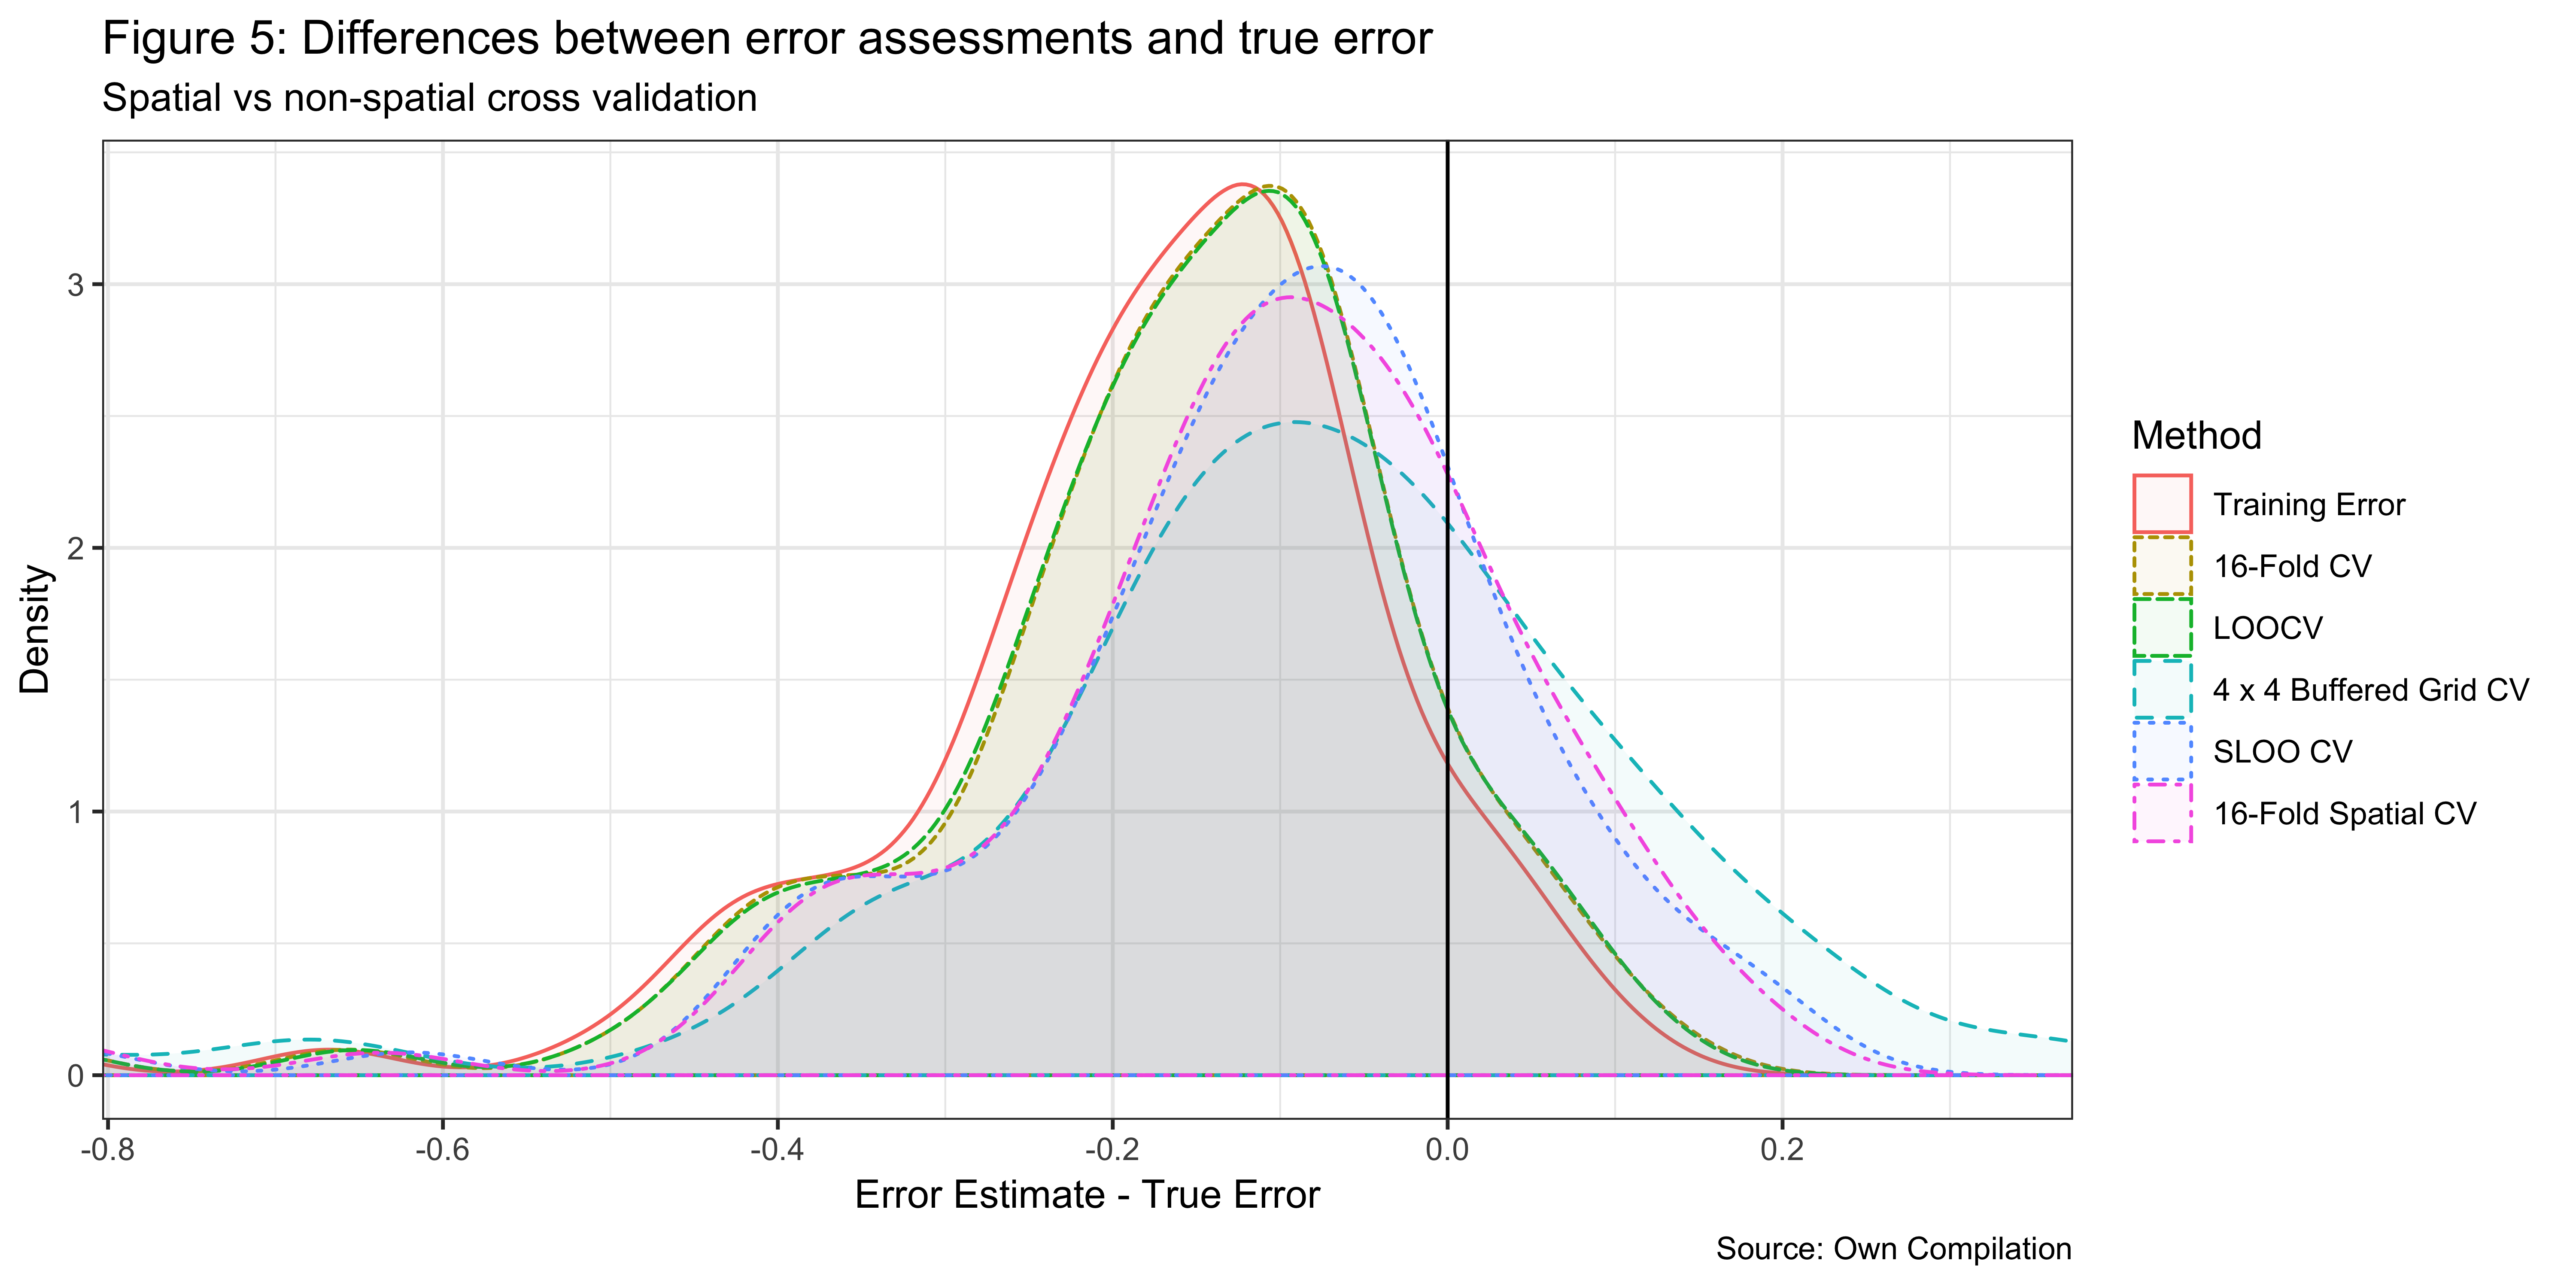

In [11]:
# Code for Figure 5
{options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 600)
output_rmse %>%
    rename(`Training Error` = err_train,
         `16-Fold CV` = err_cv,
         `LOOCV` = err_loo,
         `4 x 4 Buffered Grid CV` = err_grid_buffer,
         `SLOO CV` = err_sloo,
         `16-Fold Spatial CV` = err_scv) %>%
    gather(
        key = Method, value = estimate, 
        `Training Error`:`16-Fold Spatial CV`) %>%
  mutate(Method = factor(Method, levels = c("Training Error", "16-Fold CV", "LOOCV", 
                                            "4 x 4 Buffered Grid CV", "SLOO CV", "16-Fold Spatial CV"))) %>%
  ggplot((aes(x = estimate-err_true))) +
  geom_density(aes(color = Method, fill = Method, linetype = Method), alpha = 0.05) +
  scale_fill_discrete(name='Method',labels=c("Training Error", "16-Fold CV", "LOOCV", 
                                             "4 x 4 Buffered Grid CV", "SLOO CV", "16-Fold Spatial CV")) +
  scale_color_discrete(name='Method',labels=c("Training Error", "16-Fold CV", "LOOCV", 
                                              "4 x 4 Buffered Grid CV", "SLOO CV", "16-Fold Spatial CV")) +
  geom_vline(xintercept=0) +
  coord_cartesian(xlim=c(-0.75, 0.32)) +
  labs(
    y="Density",
    x="Error Estimate - True Error",
    title="Figure 5: Differences between error assessments and true error",
    caption="Source: Own Compilation",
    subtitle = "Spatial vs non-spatial cross validation"
  ) + theme_bw()
 }

## Model Selection Simulation
<p style='text-align: justify;'>
While model assessment is useful on its own, it is also frequently used to compare models. Therefore, this section evaluates CV for model selection within the context of spatial data analysis. 
<br> <br> 
Researchers have developed a vast variety of model selection methods for different modelling frameworks and selection goals. For example, the Akaike's Information Criterion (AIC) and the Bayesian Information Criterion (BIC) are both analytic model selection criteria that see frequent use in a wide range of application. Nevertheless, this notebook, focuses on CV, a nonparametric model assessment method, for two primary reasons. First, it is not apparent how the theoretical justifications for AIC and BIC extend to spatial contexts where independence assumptions break down. Second, extending these methods to different models is more difficult than similar extensions of CV, which needs no modification in most cases. In general, CV is much easier to understand than AIC, or BIC, which can make it more appealing to use, particularly for non-statisticians.
<br> <br> 
In model selection, the goal is to choose the "best" model from a family of potential models. In general, the "best" model for a given problem can be defined in two ways (Arlot and Celisse 2010): <br><br>
1. The model expected to have the least error on new data (selection for estimation) <br> 
2. The simplest model that can effectively describe the data (selection for identification) <br> <br> 
In selection for estimation, the goal is to choose the model that will have the least error on new data, given training set $D$. Doing so involves estimating the conditional test error $Err_D$ of the candidate models and selecting the one with the lowest $Err_D$. Selection for identification, on the other hand, aims to choose the model that best describes the underlying patterns in the population (Kim, 2009). Such a model would produce low-error estimates not only if trained on the given $D$ , but also if trained on a new $D^{\prime}$ drawn from the same population. Selection-for-estimation methods thus select the models with the lowest $Err$. However, since CV is a better estimator of $Err$ (as shown above), this section focuses on selection for identification.
 <br> <br> 
The model selection simulations employ the same five CV methods from the assessment simulation. Namely, 16-fold CV, LOO CV, 4x4 buffered grid CV, SLOO CV (with buffer size 15) and 16-fold spatial CV. However, the data-generating function is now given by:
<br> <br> 
$$
f (x_1 , x_2) = 2 \sin ( \pi x_1 ) + 2 x_2
$$
<br>
For each dataset $D$ the five error estimates are computed for four models:<br> 
1. $M_1: y \sim x_1$ (underspecified model 1)<br> 
2. $M_2: y \sim x_2$ (underspecified model 2)<br> 
3. $M_3: y \sim x_1 + x_2$ (true model)<br> 
4. $M_4: y \sim x_1 + x_2 + x_3$ (overspecified model) 
<br> <br> 
Each model-assessment method "selects" the model $M_i$ that it estimates to have the lowest out-of-sample RMSE.
</p>

**NB: Please note that the code chunk below involves multiple simulations and thus it is not feasible to run in a short time (it takes approximately 60 minutes). Therefore, I have included the results of the simulations in the next code block, which can be read in directly [here](#code_2).**

In [12]:
# Simulation study of different methods for model selection

# METHODS:
# Data: simulated data
#  - 500 observations on 100x100 grid
#  - Spatially correlated variables X1, X2
#  - Spatially correlated noise
# True model: function of X1, X2
# Fit model: linear regression
# CV strategies:
#  1) Training error
#  2) K-fold CV
#  3) LOO CV
#  4) Buffered Grid CV
#  5) Spatial LOO CV
#  6) Spatial K-Fold CV 
# Error metric: RMSE

  for (tuple in list(c(T,T))) {
      
    tic()
    
    SP_VARS <- tuple[1]   # Whether vars are spat. correlated. Default = TRUE
    SP_NOISE <- tuple[2]   # Whether noise is spat. correlated. Default = TRUE
    
    # Define true model
    f <- function(a,b,c){
      # original function
      return(2*sin(pi*a)+2*b)
    }
    
    # Generate random samples
    all_samps <- vector(mode = "list", length = NUMSAMP)
    all_samps <- lapply(all_samps, function(x) {
      generate_sample(f, spat_vars=SP_VARS, spat_noise=SP_NOISE, npoints=NPOINTS)})
    
    # Compute true error and error estimates (1-6) for each sample, model
    # --> Select model with least error
    sel_df <- data.frame()
    for (i in 1:NUMSAMP) {
      # Get sample i
      df_sim_i <- all_samps[[i]]
      model_formulas <- list(
        as.formula("val ~ X1"),
        as.formula("val ~ X2"),
        as.formula("val ~ X1 + X2"),
        as.formula("val ~ X1 + X2 + X3"))
      
      # Compute training error (1) for each model
      get_err_train <- function(formula) {
        model_lm <- lm(formula, data=df_sim_i)
        return(rmse(predict(model_lm, df_sim_i), df_sim_i$val))
      }
      errs_train <- lapply(model_formulas, get_err_train)
      # Select model with lowest training error
      sel_train <- which.min(errs_train)
      
      # Compute K-fold CV error (2) for each model
      get_err_cv <- function(formula) {
        return(cv_lm(df_sim_i, NFOLDS, model_formula=formula))
      }
      errs_cv <- lapply(model_formulas, get_err_cv)
      # Select model with lowest K-fold CV error
      sel_cv <- which.min(errs_cv)
      
      # Compute LOO CV error (3) for each model
      get_err_loo <- function(formula) {
        return(cv_lm(df_sim_i, NPOINTS, model_formula=formula))
      }
      errs_loo <- lapply(model_formulas, get_err_loo)
      # Select model with lowest K-fold CV error
      sel_loo <- which.min(errs_loo)
      
      # Compute buffered grid CV error (4) for each model
      get_err_grid <- function(formula) {
        return(cv_grid_buffer_lm(df_sim_i, NROW, NCOL, model_formula=formula))
      }
      errs_grid <- lapply(model_formulas, get_err_grid)
      # Select model with lowest buffered grid CV error
      sel_grid <- which.min(errs_grid)
      
      # Compute SLOO CV error (5) for each model
      get_err_sloo <- function(formula) {
        return(cv_SLOO_lm(df_sim_i, BUFFER, model_formula=formula))
      }
      errs_sloo <- lapply(model_formulas, get_err_sloo)
      # Select model with lowest buffered grid CV error
      sel_sloo <- which.min(errs_sloo)
      
      # Compute Spatial K-fold CV error (6) for each model
      get_err_cv_spatial <- function(formula) {
        return(cv_spatial(df_sim_i, NFOLDS, model_formula=formula))
      }
      errs_cv_spatial <- lapply(model_formulas, get_err_cv_spatial)
      # Select model with lowest spatial K-fold CV error
      sel_cv_spatial <- which.min(errs_cv_spatial)
      
      # Bind all the results
      sel_df <- rbind(sel_df, c(i, sel_train, sel_cv, sel_loo, sel_grid, sel_sloo, sel_cv_spatial))
        
    print(i)  # keep track of progress while simulation is running. (1 - 100)
        
    }
    colnames(sel_df) <- c("set_number", "sel_train", "sel_cv", "sel_loo", 
                          "sel_grid", "sel_sloo", "sel_cv_spatial")
    # Output results from model selection
    output_selection <- sel_df
    
    # run time  
    toc()
  }

In [13]:
# save the output_selection for future use
#saveRDS(output_selection,"../data/output_selection.RDS")

<a id='code_2'></a>

In [14]:
# read in simulation results `output_selection` 
output_selection <- readRDS("../data/output_selection.RDS")

<p style='text-align: justify;'>
[Table 2](#table_2) shows the results for the model selection simulation performed with spatial autocorrelation (as described above) and shows the number of times each model was selected by each model assessment method. Ideally, one wants the selection methods to choose the true model $M_3$, in bold. Interestingly, one finds that the spatial methods significantly outperform their non-spatial counterparts on the spatial data. Furthermore, the non-spatial methods tend to select the overspecified model $M_4$ the majority of the time, while the spatial methods, unlike the non-spatial ones, all select the correct model $M_3$ over 70% of the time.
<br> <br> 
Therefore, overall, the selection simulations show that the spatial CV methods discussed in this analysis are better at model selection than the non-spatial CV methods. 
</p>
<a id='table_2'></a>

In [15]:
# Code for Table 2
{order_vec <- c("Training Error", "16-Fold CV", "LOOCV", "4 x 4 Buffered Grid CV", "16-Fold Spatial CV", "SLOO CV")
output_selection %>%
    rename(`Training Error` = sel_train,
           `16-Fold CV` = sel_cv,
           `LOOCV` = sel_loo,
           `4 x 4 Buffered Grid CV` = sel_grid,
           `SLOO CV` = sel_sloo,
           `16-Fold Spatial CV` = sel_cv_spatial) %>%
    gather(`Selection Method`, model_selected, `Training Error`:`16-Fold Spatial CV`) %>%
    group_by(`Selection Method`) %>%
    summarize(
      `Selected M1 (Underspecified)` = sum(model_selected==1),
      `Selected M2 (Underspecified)` = sum(model_selected==2),
      `Selected M3 (True)` = sum(model_selected==3),
      `Selected M4 (Overspecified)` = sum(model_selected==4)) %>%
    slice(match(order_vec, `Selection Method`)) %>%   # reorder rows
    kable("html", escape = F, caption = "Table 2: Models selected by five selection methods using spatial data") %>%
    column_spec(c(1,4), bold = T) %>%
    kable_styling("hover", full_width = T) %>%
    row_spec(0, bold = T, color = "black", background = "lightgrey")  %>% 
    as.character() %>%
    IRdisplay::display_html()
 }

Table 2: Models selected by five selection methods using spatial data 
 
 
 Selection Method 
 Selected M1 (Underspecified) 
 Selected M2 (Underspecified) 
 Selected M3 (True) 
 Selected M4 (Overspecified) 
 
 
 
 
 Training Error 
 0 
 0 
 0 
 100 
 
 
 16-Fold CV 
 0 
 1 
 46 
 53 
 
 
 LOOCV 
 0 
 2 
 60 
 38 
 
 
 4 x 4 Buffered Grid CV 
 0 
 14 
 70 
 16 
 
 
 16-Fold Spatial CV 
 0 
 8 
 75 
 17 
 
 
 SLOO CV 
 0 
 8 
 76 
 16

# Conclusion
<p style='text-align: justify;'>

Spatial data presents unique challenges for cross-validation model assessment and selection. In this notebook, we explored these challenges and studied potential solutions using different techniques and multiple simulations. The simulations showed that the spatial CV methods do indeed outperform non-spatial CV methods at both *assessment* and *selection* on spatial data. More specifically, the results highlighted that spatial CV methods tend to be less over-optimistic about model performance and are also better at selecting the true model instead of an overspecified one.
<br> <br> 
In any case, the work in this notebook leaves much room for further exploration. For one, a lot of work can still be done by studying the effects of simply adjusting the parameters of the simulations and seeing how spatial and non-spatial CV methods perform for different data-generating functions, supervised learning methods, signal-to-noise ratios and levels of spatial autocorrelation. Nevertheless, the background and simulation framework provided here lays a strong foundation for understanding and exploring assessment and selection for spatially dependent data and can hopefully provide a robust point of departure for future work in this area.
</p>

# Refrences

Brenning, Alexander. 2012. “Spatial Cross-Validation and Bootstrap for the Assessment of Prediction Rules in Remote Sensing: The R Package Sperrorest.” In 2012 IEEE International Geoscience and Remote Sensing Symposium, 5372–75. Munich, Germany: IEEE. doi:10.1109/IGARSS.2012.6352393.

Legendre, Pierre. 1993. “Spatial Autocorrelation: Trouble or New Paradigm?” Ecology 74 (6): 1659–73. doi:10.2307/1939924.

Le Rest, Kévin, David Pinaud, Pascal Monestiez, Joël Chadoeuf, and Vincent Bretagnolle. 2014. “Spatial Leave-One-out Cross-Validation for Variable Selection in the Presence of Spatial Autocorrelation: Spatial Leave-One-out Cross-Validation.” Global Ecology and Biogeography 23 (7): 811–20. doi:10.1111/geb.12161.

Muenchow, J., A. Brenning, and M. Richter. 2012. “Geomorphic Process Rates of Landslides along a Humidity Gradient in the Tropical Andes.” Geomorphology 139-140: 271–84. doi:10.1016/j.geomorph.2011.10.029.

Roberts, David R., Volker Bahn, Simone Ciuti, Mark S. Boyce, Jane Elith, Gurutzeta Guillera-Arroita, Severin Hauenstein, et al. 2017. “Cross-Validation Strategies for Data with Temporal, Spatial, Hierarchical, or Phylogenetic Structure.” Ecography 40 (8): 913–29. doi:10.1111/ecog.02881.

Arlot, Sylvain, and Alain Celisse. 2010. “A Survey of Cross-Validation Procedures for Model Selection.” Statistics Surveys 4 (0): 40–79. doi:10.1214/09-SS054.

Kim, Ji-Hyun. 2009. “Estimating Classification Error Rate: Repeated Cross-Validation, Repeated Hold-out and Bootstrap.” Computational Statistics & Data Analysis 53 (11): 3735–45. doi:10.1016/j.csda.2009.04.009.

***